# Generic Object Decoding: Feature prediction
---
- This is Python code for Generic Decoding Demo. 
- Codes and Data are from  [KamitaniLab][1].  
[1]:https://github.com/KamitaniLab/GenericObjectDecoding/tree/master/code/python  
- All scripts are tested with Python 3.8.8

Analysis summary
----------------

- Learning method:   Sparse linear regression
- Preprocessing:     Normalization and voxel selection
- Data:              GenericDecoding_demo
- Results format:    Pandas dataframe
---
### Data
- All data should be placed in python/data. 
- Data can be obrained from [figshare][2].
[2]:https://figshare.com/articles/dataset/Generic_Object_Decoding/7387130
- The data directory should have the following files:


      data/ --+-- Subject1.h5 (fMRI data, subject 1)
              |
              +-- Subject2.h5 (fMRI data, subject 2)
              |
              +-- Subject3.h5 (fMRI data, subject 3)
              |
              +-- Subject4.h5 (fMRI data, subject 4)
              |
              +-- Subject5.h5 (fMRI data, subject 5)
              |
              +-- ImageFeatures.h5 (image features extracted with Matconvnet)

In [3]:
! pip3 install bdpy

  Using cached bdpy-0.16-py2.py3-none-any.whl (74 kB)
  Using cached hdf5storage-0.1.18-py2.py3-none-any.whl (53 kB)


In [1]:
from __future__ import print_function

import os
import sys
import pickle
from itertools import product
from time import time

import numpy as np
import pandas as pd
from scipy import stats

from slir import SparseLinearRegression # download slir
from sklearn.linear_model import LinearRegression  # For quick demo

import bdpy # download bdpy
from bdpy.bdata import concat_dataset
from bdpy.ml import add_bias
from bdpy.preproc import select_top
from bdpy.stats import corrcoef
from bdpy.util import makedir_ifnot, get_refdata
from bdpy.dataform import append_dataframe
from bdpy.distcomp import DistComp

import god_config as config

##  Step 1) Analysis - Feature Prediction
   #### Run image feature prediction for each subject, ROI, and layer (feature).
   #### analysis_FeaturePrediction.py
   - feature_prediction()
   - get_averaged_feature()
   - main()
   ---
##### * feature_prediction()
   Run feature prediction

In [2]:
def feature_prediction(x_train, y_train, x_test, y_test, n_voxel=500, n_iter=200):

    n_unit = y_train.shape[1] # 100 units 

    # Normalize brian data (x)
    norm_mean_x = np.mean(x_train, axis=0)
    norm_scale_x = np.std(x_train, axis=0, ddof=1)

    x_train = (x_train - norm_mean_x) / norm_scale_x
    x_test = (x_test - norm_mean_x) / norm_scale_x

    # Feature prediction for each unit
    print('Running feature prediction')

    y_true_list = []
    y_pred_list = []

    for i in range(n_unit):

        print('Unit %03d' % (i + 1))
        start_time = time()

        # Get unit features
        y_train_unit = y_train[:, i]
        y_test_unit =  y_test[:, i]

        # Normalize image features for training (y_train_unit)
        norm_mean_y = np.mean(y_train_unit, axis=0)
        std_y = np.std(y_train_unit, axis=0, ddof=1)
        norm_scale_y = 1 if std_y == 0 else std_y

        y_train_unit = (y_train_unit - norm_mean_y) / norm_scale_y

        # Voxel selection
        corr = corrcoef(y_train_unit, x_train, var='col')

        x_train_unit, voxel_index = select_top(x_train, np.abs(corr), n_voxel, axis=1, verbose=False)
        x_test_unit = x_test[:, voxel_index]

        # Add bias terms
        x_train_unit = add_bias(x_train_unit, axis=1)
        x_test_unit = add_bias(x_test_unit, axis=1)

        # Setup regression
        # For quick demo, use linaer regression
        model = LinearRegression()
        #model = SparseLinearRegression(n_iter=n_iter, prune_mode=1)  # ........ optional

        # Training and test
        try:
            model.fit(x_train_unit, y_train_unit)  # Training
            y_pred = model.predict(x_test_unit)    # Test
        except:
            # When SLiR failed, returns zero-filled array as predicted features
            y_pred = np.zeros(y_test_unit.shape)

        # Denormalize predicted features
        y_pred = y_pred * norm_scale_y + norm_mean_y

        y_true_list.append(y_test_unit)
        y_pred_list.append(y_pred)

        print('Time: %.3f sec' % (time() - start_time))

    # Create numpy arrays for return values
    y_predicted = np.vstack(y_pred_list).T
    y_true = np.vstack(y_true_list).T

    return y_predicted, y_true

##### * get_averaged_feature()
  Return category-averaged features

In [3]:
def get_averaged_feature(pred_y, true_y, labels):

    labels_set = np.unique(labels)

    pred_y_av = np.array([np.mean(pred_y[labels == c, :], axis=0) for c in labels_set])
    true_y_av = np.array([np.mean(true_y[labels == c, :], axis=0) for c in labels_set])

    return pred_y_av, true_y_av, labels_set

##### * main()

In [4]:
# Data settings
subjects = config.subjects
rois = config.rois
num_voxel = config.num_voxel

image_feature = config.image_feature_file
features = config.features

n_iter = 200

results_dir = config.results_dir

# Misc settings
# analysis_basename = os.path.basename(__file__)
analysis_basename = 'analysis_FeaturePrediction.py' # ...........for Jupyter

### Load data

In [5]:
print('----------------------------------------')
print('Loading data')

data_all = {}

''' ....................................................................For quick test,
Edit <god_config.py>, or include & edit belows

# subjects = {'Subject1' : ['data/Subject1.h5'],
            'Subject2' : ['data/Subject2.h5'],
            'Subject3' : ['data/Subject3.h5'],
            'Subject4' : ['data/Subject4.h5'],
            'Subject5' : ['data/Subject5.h5']}
# rois = {'VC' : 'ROI_VC = 1',
        'LVC' : 'ROI_LVC = 1',
        'HVC' : 'ROI_HVC = 1',
        'V1' : 'ROI_V1 = 1',
        'V2' : 'ROI_V2 = 1',
        'V3' : 'ROI_V3 = 1',
        'V4' : 'ROI_V4 = 1',
        'LOC' : 'ROI_LOC = 1',
        'FFA' : 'ROI_FFA = 1',
        'PPA' : 'ROI_PPA = 1'}
# features = ['cnn1', 'cnn2', 'cnn3', 'cnn4', 'cnn5', 'cnn6', 'cnn7', 'cnn8', 'hmax1', 'hmax2', 'hmax3', 'gist', 'sift']
'''
for sbj in subjects:
    if len(subjects[sbj]) == 1:
        data_all[sbj] = bdpy.BData(subjects[sbj][0])
    else:
        # Concatenate data
        suc_cols = ['Run', 'Block']
        data_all[sbj] = concat_dataset([bdpy.BData(f) for f in subjects[sbj]],
                                       successive=suc_cols)

data_feature = bdpy.BData(image_feature)


----------------------------------------
Loading data


###  Add any additional processing to data here

### Initialize directories

In [6]:
makedir_ifnot(results_dir)
makedir_ifnot('tmp')

False

### Analysis loop

In [7]:
print('----------------------------------------')
print('Analysis loop')
print(subjects)#tmp
for sbj, roi, feat in product(subjects, rois, features):
    print('--------------------')
    print('Subject:    %s' % sbj)
    print('ROI:        %s' % roi)
    print('Num voxels: %d' % num_voxel[roi])
    print('Feature:    %s' % feat)

    # Distributed computation
    analysis_id = analysis_basename + '-' + sbj + '-' + roi + '-' + feat
    
    results_file = os.path.join(results_dir, analysis_id + '.pkl')
    print(results_file)
    if os.path.exists(results_file):
        # print('%s is already done. Skipped.' % analysis_id) # ......tmp
        continue
    '''
    dist = DistComp(lockdir='tmp', comp_id=analysis_id)
    if dist.islocked():
        print('%s is already running. Skipped.' % analysis_id)
        continue

    dist.lock()
    '''
    # Prepare data
    print('Preparing data')
    dat = data_all[sbj]

    x = dat.select(rois[roi])           # Brain data
    datatype = dat.select('DataType')   # Data type
    labels = dat.select('stimulus_id')  # Image labels in brain data

    y = data_feature.select(feat)             # Image features
    y_label = data_feature.select('ImageID')  # Image labels

    # For quick demo, reduce the number of units from 1000 to 100
    y = y[:, :100]

    y_sorted = get_refdata(y, y_label, labels)  # Image features corresponding to brain data

    # Get training and test dataset
    i_train = (datatype == 1).flatten()    # Index for training
    i_test_pt = (datatype == 2).flatten()  # Index for perception test
    i_test_im = (datatype == 3).flatten()  # Index for imagery test
    i_test = i_test_pt + i_test_im

    x_train = x[i_train, :]
    x_test = x[i_test, :]

    y_train = y_sorted[i_train, :]
    y_test = y_sorted[i_test, :]

    # Feature prediction
    pred_y, true_y = feature_prediction(x_train, y_train,
                                        x_test, y_test,
                                        n_voxel=num_voxel[roi],
                                        n_iter=n_iter)

    # Separate results for perception and imagery tests
    i_pt = i_test_pt[i_test]  # Index for perception test within test
    i_im = i_test_im[i_test]  # Index for imagery test within test

    pred_y_pt = pred_y[i_pt, :]
    pred_y_im = pred_y[i_im, :]

    true_y_pt = true_y[i_pt, :]
    true_y_im = true_y[i_im, :]

    # Get averaged predicted feature
    test_label_pt = labels[i_test_pt, :].flatten()
    test_label_im = labels[i_test_im, :].flatten()

    pred_y_pt_av, true_y_pt_av, test_label_set_pt \
        = get_averaged_feature(pred_y_pt, true_y_pt, test_label_pt)
    pred_y_im_av, true_y_im_av, test_label_set_im \
        = get_averaged_feature(pred_y_im, true_y_im, test_label_im)

    # Get category averaged features
    catlabels_pt = np.vstack([int(n) for n in test_label_pt])  # Category labels (perception test)
    catlabels_im = np.vstack([int(n) for n in test_label_im])  # Category labels (imagery test)
    catlabels_set_pt = np.unique(catlabels_pt)                 # Category label set (perception test)
    catlabels_set_im = np.unique(catlabels_im)                 # Category label set (imagery test)

    y_catlabels = data_feature.select('CatID')   # Category labels in image features
    ind_catave = (data_feature.select('FeatureType') == 3).flatten()

    y_catave_pt = get_refdata(y[ind_catave, :], y_catlabels[ind_catave, :], catlabels_set_pt)
    y_catave_im = get_refdata(y[ind_catave, :], y_catlabels[ind_catave, :], catlabels_set_im)

    # Prepare result dataframe
    results = pd.DataFrame({'subject' : [sbj, sbj],
                            'roi' : [roi, roi],
                            'feature' : [feat, feat],
                            'test_type' : ['perception', 'imagery'],
                            'true_feature': [true_y_pt, true_y_im],
                            'predicted_feature': [pred_y_pt, pred_y_im],
                            'test_label' : [test_label_pt, test_label_im],
                            'test_label_set' : [test_label_set_pt, test_label_set_im],
                            'true_feature_averaged' : [true_y_pt_av, true_y_im_av],
                            'predicted_feature_averaged' : [pred_y_pt_av, pred_y_im_av],
                            'category_label_set' : [catlabels_set_pt, catlabels_set_im],
                            'category_feature_averaged' : [y_catave_pt, y_catave_im]})

    # Save results
    makedir_ifnot(os.path.dirname(results_file))
    with open(results_file, 'wb') as f:
        pickle.dump(results, f)

    #print('Saved %s' % results_file) #.....................tmp

    #dist.unlock()   #.............................tmp

print('Saved result files')

----------------------------------------
Analysis loop
{'Subject1': ['data/Subject1.h5'], 'Subject2': ['data/Subject2.h5'], 'Subject3': ['data/Subject3.h5'], 'Subject4': ['data/Subject4.h5'], 'Subject5': ['data/Subject5.h5']}
--------------------
Subject:    Subject1
ROI:        VC
Num voxels: 1000
Feature:    cnn1
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-VC-cnn1.pkl
--------------------
Subject:    Subject1
ROI:        VC
Num voxels: 1000
Feature:    cnn2
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-VC-cnn2.pkl
--------------------
Subject:    Subject1
ROI:        VC
Num voxels: 1000
Feature:    cnn3
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-VC-cnn3.pkl
--------------------
Subject:    Subject1
ROI:        VC
Num voxels: 1000
Feature:    cnn4
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject1-VC-cnn4.pkl
--------------------
Subject:    Subject1
ROI:        VC
Num voxels: 1000
Feature:    

--------------------
Subject:    Subject5
ROI:        V3
Num voxels: 500
Feature:    cnn3
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V3-cnn3.pkl
--------------------
Subject:    Subject5
ROI:        V3
Num voxels: 500
Feature:    cnn4
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V3-cnn4.pkl
--------------------
Subject:    Subject5
ROI:        V3
Num voxels: 500
Feature:    cnn5
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V3-cnn5.pkl
--------------------
Subject:    Subject5
ROI:        V3
Num voxels: 500
Feature:    cnn6
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V3-cnn6.pkl
--------------------
Subject:    Subject5
ROI:        V3
Num voxels: 500
Feature:    cnn7
results\GenericObjectDecoding\analysis_FeaturePrediction.py-Subject5-V3-cnn7.pkl
--------------------
Subject:    Subject5
ROI:        V3
Num voxels: 500
Feature:    cnn8
results\GenericObjectDecoding\analysis_FeaturePredictio

##  Step 2) Analysis - Feature Prediction Merge Results
   ####  Merge outputs of analysis_FeaturePrediction.py and calculate feature prediction accuracy.
   ####  analysis_FeaturePredictionMergeResults.py
   - main()

In [8]:
results_dir = config.results_dir
output_file = config.results_file

# Load results -----------------------------------------------------
result_list = []
for rf in os.listdir(results_dir):
    rf_full = os.path.join(results_dir, rf)
    # print('Loading %s' % rf_full) # ....tmp
    with open(rf_full, 'rb') as f:
        res = pickle.load(f)
    result_list.append(res)

# Merge result dataframes ------------------------------------------
results = pd.concat(result_list, ignore_index=True)

# Drop unnecessary columns
results.drop('predicted_feature', axis=1, inplace=True)
results.drop('true_feature', axis=1, inplace=True)
results.drop('test_label', axis=1, inplace=True)

# Calculated feature prediction accuracy ---------------------------
res_pt = results.query('test_type == "perception"')
res_im = results.query('test_type == "imagery"')

# Profile correlation (image)
res_pt['profile_correlation_image'] = [corrcoef(t, p, var='col')
                                       for t, p in zip(res_pt['true_feature_averaged'],
                                                       res_pt['predicted_feature_averaged'])]
res_pt['mean_profile_correlation_image'] = res_pt.loc[:, 'profile_correlation_image'].apply(np.nanmean)

# Profile correlation (category, seen)
res_pt['profile_correlation_cat_percept'] = [corrcoef(t, p, var='col')
                                             for t, p in zip(res_pt['category_feature_averaged'],
                                                             res_pt['predicted_feature_averaged'])]
res_pt['mean_profile_correlation_cat_percept'] = res_pt.loc[:, 'profile_correlation_cat_percept'].apply(np.nanmean)

# Profile correlation (category, imagined)
res_im['profile_correlation_cat_imagery'] = [corrcoef(t, p, var='col')
                                             for t, p in zip(res_im['category_feature_averaged'],
                                                             res_im['predicted_feature_averaged'])]
res_im['mean_profile_correlation_cat_imagery'] = res_im.loc[:, 'profile_correlation_cat_imagery'].apply(np.nanmean)

# Merge results
results_merged = pd.merge(res_pt, res_im, on=['subject', 'roi', 'feature'])

# Rename columns
results_merged = results_merged.rename(columns={'test_label_set_x' : 'test_label_set_percept',
                                                'test_label_set_y' : 'test_label_set_imagery',
                                                'true_feature_averaged_x' : 'true_feature_averaged_percept',
                                                'true_feature_averaged_y' : 'true_feature_averaged_imagery',
                                                'predicted_feature_averaged_x' : 'predicted_feature_averaged_percept',
                                                'predicted_feature_averaged_y' : 'predicted_feature_averaged_imagery',
                                                'category_label_set_x' : 'category_label_set_percept',
                                                'category_label_set_y' : 'category_label_set_imagery',
                                                'category_feature_averaged_x' : 'category_feature_averaged_percept',
                                                'category_feature_averaged_y' : 'category_feature_averaged_imagery'})

# Drop unnecessary columns
results_merged.drop('test_type_x', axis=1, inplace=True)
results_merged.drop('test_type_y', axis=1, inplace=True)

# Save the merged dataframe ----------------------------------------    
with open(output_file, 'wb') as f:
    pickle.dump(results_merged, f)
print('Saved %s' % output_file)


D:\INSTALL\Anaconda\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
D:\INSTALL\Anaconda\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
<ipython-input-8-31e12d3fe069>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_pt['profile_correlation_image'] = [corrcoef(t, p, var='col')
<ipython-input-8-31e12d3fe069>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view

Saved results\GenericObjectDecoding.pkl


<ipython-input-8-31e12d3fe069>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_im['profile_correlation_cat_imagery'] = [corrcoef(t, p, var='col')
<ipython-input-8-31e12d3fe069>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_im['mean_profile_correlation_cat_imagery'] = res_im.loc[:, 'profile_correlation_cat_imagery'].apply(np.nanmean)


##  Step 3) Analysis - Category Identification
   #### Run category identification.
   #### analysis_CategoryIdentification.py
   - get_pwident_correctrate()
   - main()   
   ---
##### * get_pwident_correctrate()
   Returns correct rate in pairwise identification   
   - Parameters   
    simmat : numpy array [num_prediction * num_category]
       (Similarity matrix)  
   - Returns  
    correct_rate : correct rate of pair-wise identification

In [9]:
def get_pwident_correctrate(simmat):
    
    num_pred = simmat.shape[0]
    labels = range(num_pred)

    correct_rate = []
    for i in range(num_pred):
    # for i in xrange(num_pred):
        pred_feat = simmat[i, :]
        correct_feat = pred_feat[labels[i]]
        pred_num = len(pred_feat) - 1
        correct_rate.append((pred_num - np.sum(pred_feat > correct_feat)) / float(pred_num))

    return correct_rate

##### * main()

In [10]:
from bdpy.stats import corrmat # ..........for Jupyter

results_dir = config.results_dir
output_file = config.results_file

image_feature_file = config.image_feature_file

# Load results -----------------------------------------------------
print('Loading %s' % output_file)
with open(output_file, 'rb') as f:
    results = pickle.load(f)

data_feature = bdpy.BData(image_feature_file)

# Category identification ------------------------------------------
print('Running pair-wise category identification')

feature_list = results['feature']
pred_percept = results['predicted_feature_averaged_percept']
pred_imagery = results['predicted_feature_averaged_imagery']
cat_label_percept = results['category_label_set_percept']
cat_label_imagery = results['category_label_set_imagery']
cat_feature_percept = results['category_feature_averaged_percept']
cat_feature_imagery = results['category_feature_averaged_imagery']

ind_cat_other = (data_feature.select('FeatureType') == 4).flatten()

pwident_cr_pt = []  # Prop correct in pair-wise identification (perception)
pwident_cr_im = []  # Prop correct in pair-wise identification (imagery)

for f, fpt, fim, pred_pt, pred_im in zip(feature_list, cat_feature_percept, cat_feature_imagery,
                                         pred_percept, pred_imagery):
    feat_other = data_feature.select(f)[ind_cat_other, :]

    n_unit = fpt.shape[1]
    feat_other = feat_other[:, :n_unit]

    feat_candidate_pt = np.vstack([fpt, feat_other])
    feat_candidate_im = np.vstack([fim, feat_other])

    simmat_pt = corrmat(pred_pt, feat_candidate_pt)
    simmat_im = corrmat(pred_im, feat_candidate_im)

    cr_pt = get_pwident_correctrate(simmat_pt)
    cr_im = get_pwident_correctrate(simmat_im)

    pwident_cr_pt.append(np.mean(cr_pt))
    pwident_cr_im.append(np.mean(cr_im))

results['catident_correct_rate_percept'] = pwident_cr_pt
results['catident_correct_rate_imagery'] = pwident_cr_im

# Save the merged dataframe ----------------------------------------
with open(output_file, 'wb') as f:
    pickle.dump(results, f)
print('Saved %s' % output_file)

# Show results -----------------------------------------------------
tb_pt = pd.pivot_table(results, index=['roi'], columns=['feature'],
                       values=['catident_correct_rate_percept'], aggfunc=np.mean)
tb_im = pd.pivot_table(results, index=['roi'], columns=['feature'],
                       values=['catident_correct_rate_imagery'], aggfunc=np.mean)

print(tb_pt)
print(tb_im)


Loading results\GenericObjectDecoding.pkl
Running pair-wise category identification


D:\INSTALL\Anaconda\lib\site-packages\bdpy\stats\corr.py:114: RuntimeWarning: invalid value encountered in true_divide
  cmat = (np.dot(submean(x), submean(y).T) / (nobs - 1)) / np.dot(np.matrix(np.std(x, axis=1, ddof=1)).T, np.matrix(np.std(y, axis=1, ddof=1)))


Saved results\GenericObjectDecoding.pkl
        catident_correct_rate_percept                                          \
feature                          cnn1      cnn2      cnn3      cnn4      cnn5   
roi                                                                             
FFA                          0.502776  0.655932  0.772501  0.792161  0.805897   
HVC                          0.506054  0.676684  0.782479  0.787855  0.798298   
LOC                          0.508777  0.653002  0.775760  0.804008  0.815537   
LVC                          0.486850  0.664648  0.732624  0.776621  0.761694   
PPA                          0.529719  0.659691  0.758184  0.789600  0.805660   
V1                           0.548911  0.708903  0.736815  0.752997  0.797413   
V2                           0.551971  0.706397  0.754549  0.778669  0.806330   
V3                           0.528942  0.710857  0.783651  0.804433  0.829249   
V4                           0.508099  0.697595  0.802470  0.838021  

##  Step 4) Create Figures
   #### Create result figures.
   #### createfigure.py
   - plotresults()
   - main()
   ---
##### * plotresults()
   Draw results of feature prediction

In [11]:
def plotresults(fig, results, value_key='', roi_label=[], feature_label=[],
                subplot_index=[], caption='', barcolor=[0.4, 0.4, 0.4],
                ylabel='', ylim=[-1, 1], ytick=[], textpos=[0, -0.12]):
    '''Draw results of feature prediction'''

    # Get mean and confidence interval ---------------------------------
    tb_mean = pd.pivot_table(results, index=['roi'], columns=['feature'],
                             values=[value_key], aggfunc=np.mean)
    tb_sem = pd.pivot_table(results, index=['roi'], columns=['feature'],
                            values=[value_key], aggfunc=st.sem)
    tb_num = pd.pivot_table(results, index=['roi'], columns=['feature'],
                            values=[value_key], aggfunc=len)

    tb_mean = tb_mean.reindex(index=roi_label)
    tb_sem = tb_sem.reindex(index=roi_label)
    tb_num = tb_num.reindex(index=roi_label)

    ci = st.t.interval(1 - 0.05, tb_num, loc=tb_mean, scale=tb_sem)
    tb_yerr = (tb_mean - ci[0], ci[1] - tb_mean)

    # Plot -------------------------------------------------------------
    xpos = range(len(roi_label))

    for feat, si in zip(tb_mean, subplot_index):
        plt.subplot(8, 6, si)

        # Draw results
        y = tb_mean[feat]
        yerr = (tb_yerr[0][feat], tb_yerr[1][feat])
        plt.bar(xpos, y, align='center',
                color=barcolor, edgecolor=barcolor,
                linewidth=2,
                yerr=yerr, ecolor='k', capsize=0)

        # Draw 'feature' name
        feat_name = caption + feat[1]
        plt.text(textpos[0], textpos[1], feat_name, fontsize=12)

        # Modify x and y axes
        plt.xticks(xpos, roi_label)
        plt.xlim([-0.5, len(xpos) - 0.5])

        plt.ylabel(ylabel)
        plt.yticks(ytick)
        plt.ylim(ylim)

        bfig.box_off(plt.gca())

        # Remove ticks on x and y axes
        plt.gca().xaxis.set_ticks_position('none')
        plt.gca().yaxis.set_ticks_position('none')

        # Horizontal grid lines
        plt.gca().yaxis.grid(True, linestyle='-', linewidth=1, color='gray')
        plt.gca().set_axisbelow(True)

    # Adjust subplots
    plt.subplots_adjust(wspace=0.4, hspace=0.2)

##### * main()

Loading results\GenericObjectDecoding.pkl
Saved results\GenericObjectDecoding_featureprediction.pdf


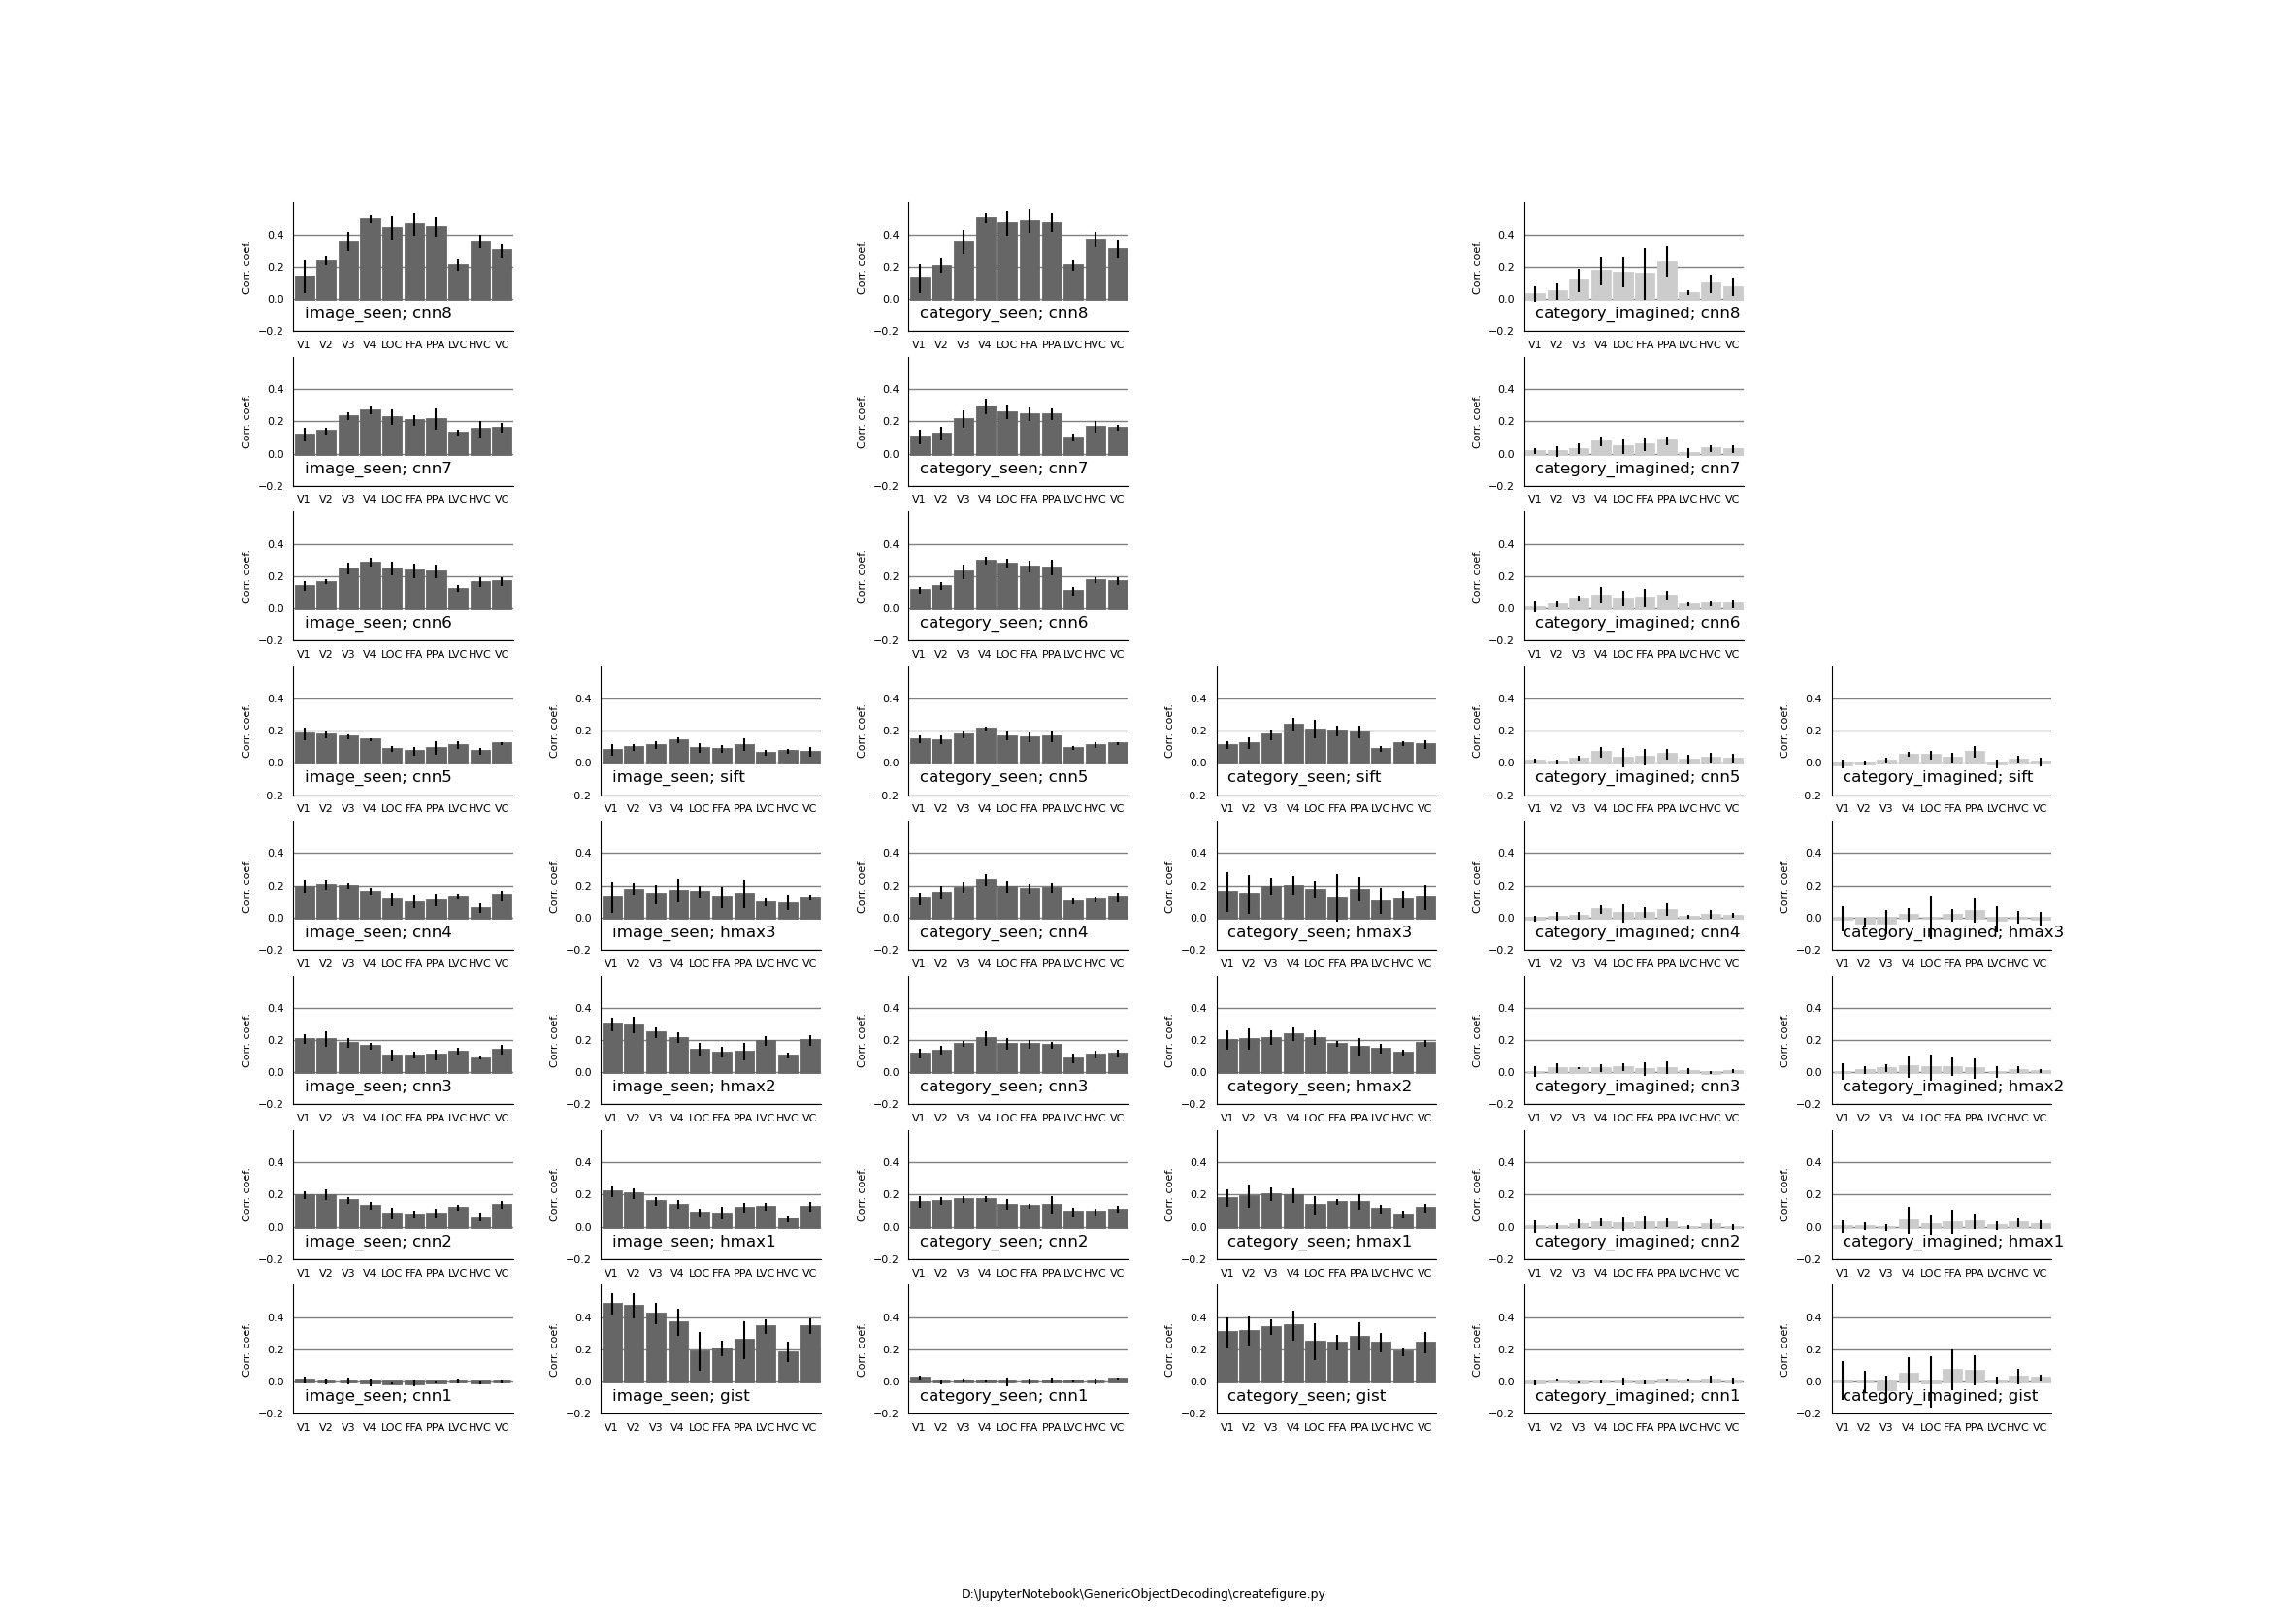

Saved results\GenericObjectDecoding_categoryidentification.pdf


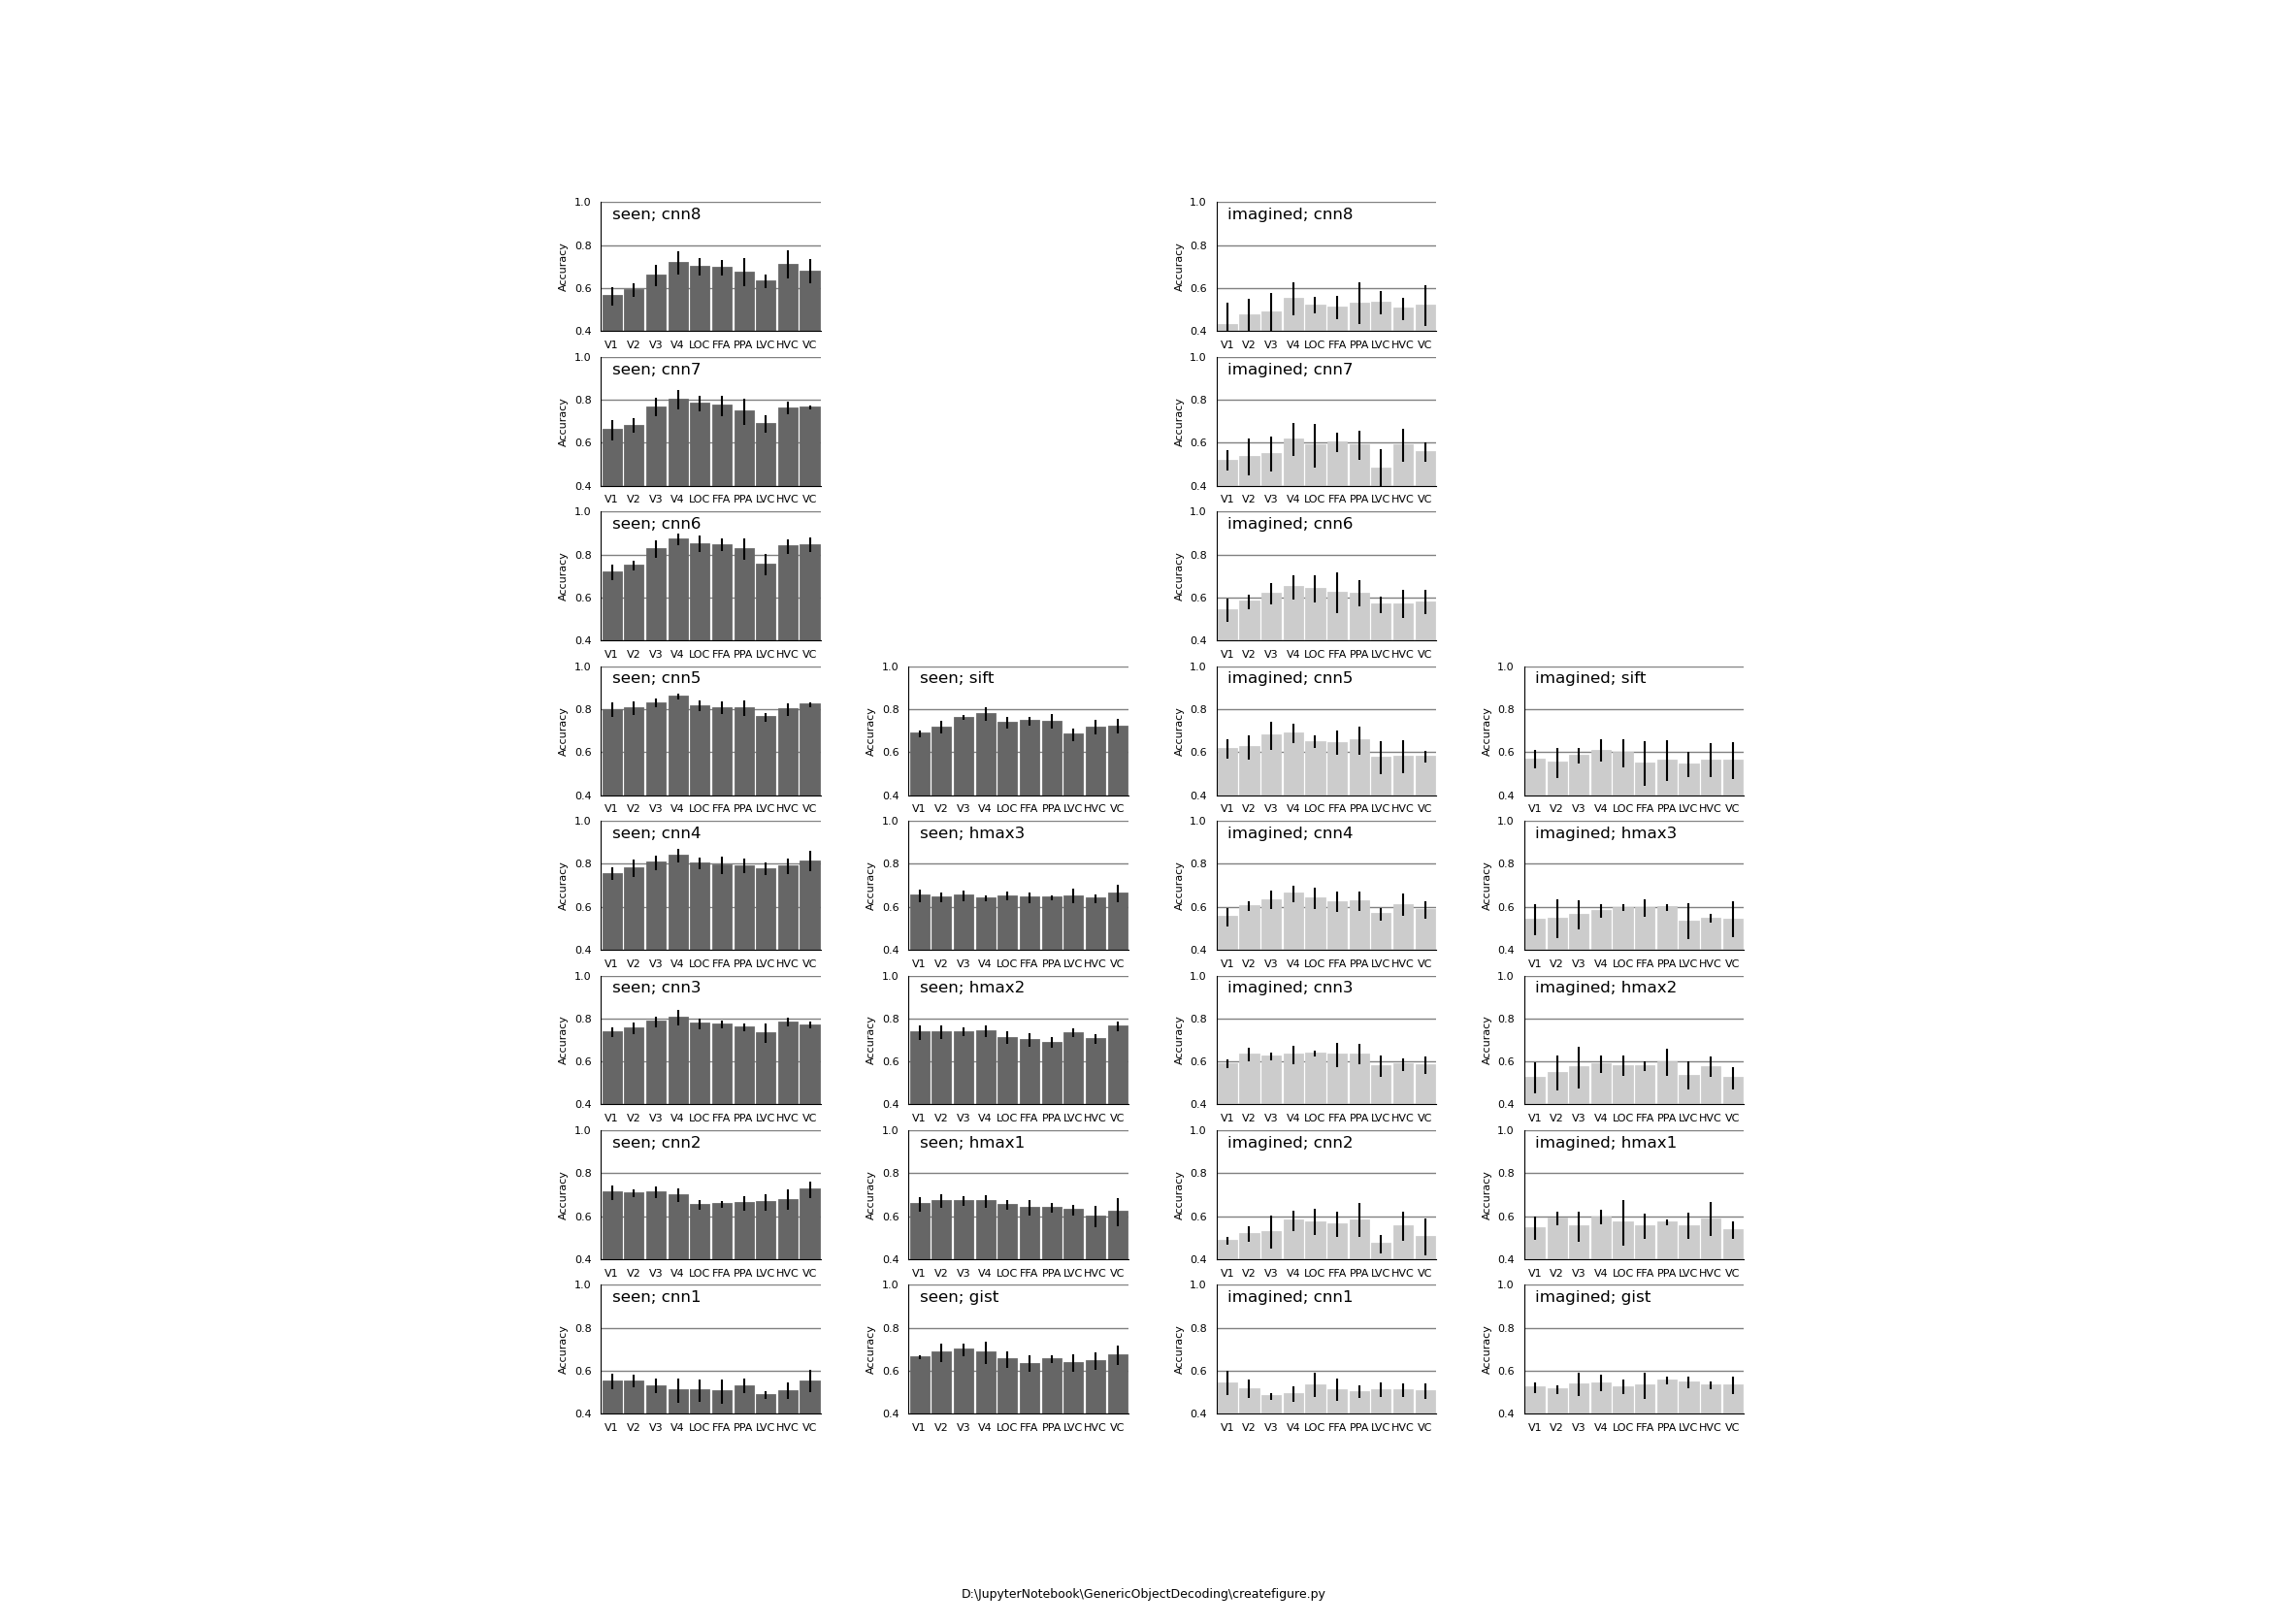

In [14]:
#.......................for Jupyter
import scipy.stats as st
import matplotlib.pyplot as plt 
import bdpy.fig as bfig
#.................................
results_file = config.results_file
output_file_featpred = os.path.join('results', config.analysis_name + '_featureprediction.pdf')
output_file_catident = os.path.join('results', config.analysis_name + '_categoryidentification.pdf')

roi_label = config.roi_labels

# Load results -----------------------------------------------------
with open(results_file, 'rb') as f:
    print('Loading %s' % results_file)
    results = pickle.load(f)

# Figure settings
plt.rcParams['font.size'] = 8

# Plot (feature prediction) ----------------------------------------
fig = plt.figure(figsize=[2 * 11.69, 2 * 8.27], dpi=100)

subplotpos_image = [43, 37, 31, 25, 19, 13, 7, 1, 44, 38, 32, 26, 20]
subplotpos_catpt = [45, 39, 33, 27, 21, 15, 9, 3, 46, 40, 34, 28, 22]
subplotpos_catim = [47, 41, 35, 29, 23, 17, 11, 5, 48, 42, 36, 30, 24]

# Image
plotresults(fig, results, value_key='mean_profile_correlation_image',
            roi_label=roi_label, subplot_index=subplotpos_image,
            caption='image_seen; ', ylabel='Corr. coef.', ylim=[-0.2, 0.6], ytick=[-0.2, 0, 0.2, 0.4])

# Category, seen
plotresults(fig, results, value_key='mean_profile_correlation_cat_percept',
            roi_label=roi_label, subplot_index=subplotpos_catpt,
            caption='category_seen; ', ylabel='Corr. coef.', ylim=[-0.2, 0.6], ytick=[-0.2, 0, 0.2, 0.4])

# Category, imagined
plotresults(fig, results, value_key='mean_profile_correlation_cat_imagery',
            roi_label=roi_label, subplot_index=subplotpos_catim,
            barcolor=[0.8, 0.8, 0.8],
            caption='category_imagined; ', ylabel='Corr. coef.', ylim=[-0.2, 0.6], ytick=[-0.2, 0, 0.2, 0.4])

# Draw path to the script
# fpath = os.path.abspath(__file__)
fpath = os.getcwd() # for Jupyter
fpath = os.path.join(fpath, 'createfigure.py')  # for Jupyter
bfig.draw_footnote(fig, fpath)

# Save the figure
plt.savefig(output_file_featpred)
print('Saved %s' % output_file_featpred)

plt.show()

# Plot (category identification) -----------------------------------
fig = plt.figure(figsize=[2 * 11.69, 2 * 8.27], dpi=100)

subplotpos_percept = [44, 38, 32, 26, 20, 14, 8, 2, 45, 39, 33, 27, 21]
subplotpos_imagery = [46, 40, 34, 28, 22, 16, 10, 4, 47, 41, 35, 29, 23]

# Image
plotresults(fig, results, value_key='catident_correct_rate_percept',
            roi_label=roi_label, subplot_index=subplotpos_percept,
            caption='seen; ', ylabel='Accuracy', ylim=[0.4, 1.0], ytick=[0.4, 0.6, 0.8, 1.0], textpos=[0, 0.92])

# Category, seen
plotresults(fig, results, value_key='catident_correct_rate_imagery',
            roi_label=roi_label, subplot_index=subplotpos_imagery,
            barcolor=[0.8, 0.8, 0.8],
            caption='imagined; ', ylabel='Accuracy', ylim=[0.4, 1.0], ytick=[0.4, 0.6, 0.8, 1.0], textpos=[0, 0.92])

# Draw path to the script

#fpath = os.path.abspath(__file__)
fpath = os.getcwd() # for Jupyter
fpath = os.path.join(fpath, 'createfigure.py')  # for Jupyter

bfig.draw_footnote(fig, fpath)

# Save the figure
plt.savefig(output_file_catident)
print('Saved %s' % output_file_catident)

plt.show()
